# Port of SARS-nCoV-2 Wuhan code (Read et al. 2022) to `gemlib`

This notebook uses `gemlib` to re-implement the model proposed by [Read et al. 2020](https://doi.org/10.1098/rstb.2020.0265) to analyse Covid19 case data in China in early 2020.  The model uses a coupled set of ordinary differential equations to implement an SEIR metapopulation model, where metapopulations represent cities in China connected to each other, and to other non-China countries, by data on the number of airline passengers going between sites.  The authors assume that the (noisy) case data is stochastically observed and, in the pandemic origin city Wuhan, subject to under-reporting.  Inference is performed using a frequentist philosophy, showing that `gemlib` may be used for frequentist as well as Bayesian analyses.

Below, we use `gemlib`'s `ode_model` interface together with TensorFlow Probability's `JointDistributionCoroutineAutoBatched` to re-create the original frequentist analysis, using maximum likelihood estimation and bootstrap sampling to compute parameter estimates, confidence intervals, and prediction intervals. 

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
import xarray as xr
from jax.typing import ArrayLike
from wuhan_helpers import expected_observed_cases, make_initial_state

from gemlib.deterministic import ode_model

%matplotlib inline
tfd = tfp.distributions

sns.set_theme()

## Loading the data

Data on daily cases (for China cities and non-China countries), Chinese city population, and (simulated) flight connectivity between Chinese cities, and Chinese cities and non-China countries are provided as a self-documenting NetCDF4 archive, which we can load using Python's `xarray` package:

In [2]:
ds = xr.load_dataset("data/wuhan_example_data.nc")
ds

<xarray.Dataset> Size: 680kB
Dimensions:             (world_country: 201, china_city: 187,
                         china_city_src: 187, date: 30)
Coordinates:
  * world_country       (world_country) object 2kB 'Afghanistan' ... 'Zimbabwe'
  * china_city_src      (china_city_src) object 1kB 'Aksu' 'Altay' ... 'Zunyi'
  * china_city          (china_city) object 1kB 'Aksu' 'Altay' ... 'Zunyi'
  * date                (date) datetime64[ns] 240B 2020-01-01 ... 2020-01-30
Data variables:
    world_connectivity  (world_country, china_city) float64 301kB 0.0 ... 0.0
    china_connectivity  (china_city, china_city_src) float64 280kB 0.0 ... 0.0
    china_population    (china_city) float64 1kB 6.6e+05 1.99e+05 ... 6.127e+06
    world_cases         (date, world_country) float64 48kB 0.0 0.0 ... 0.0 0.0
    china_cases         (date, china_city) float64 45kB nan nan nan ... 8.0 0.0

## Building a deterministic SEIR metapopulation model

We start building our model by composing the incidence matrix for an SEIR model, and building the $187 \times 4$ matrix to represent the initial state.  Below, the call to the `make_initial_state` helper function sets the first state compartment ($x^S_{it}$) of each metapopulation equal to the respective population size, except the metapopulation corresponding to Wuhan (`WUHAN_IDX`) for which it is assumed that $x^S_{150,0} = N_i - 15$ and $x^I_{150,0} = 15$, i.e. 15 initial infected individuals in Wuhan on the 1st January 2020.  If you're worried about this assumption, then read on because we estimate it from the observed data below.

In [3]:
incidence_matrix = np.array(
    [[-1, 0, 0], [1, -1, 0], [0, 1, -1], [0, 0, 1]], dtype=np.float32
)

WUHAN_IDX = np.where(ds["china_city"] == "Wuhan")[0][0]
initial_state = make_initial_state(  # Helper function sets initial conditions
    num_initial_infections=15.0,
    popsize=np.asarray(ds["china_population"]),
    initial_index=WUHAN_IDX,
)

Given the SEIR state transition model, and our state matrix, we recall that the Read et al. 2020 model assumes the following transition rate functions:

\begin{align}
\vec{\lambda}^{SE}(t, x_t) & = \beta \left(\vec{x}^{I}_t + K \cdot (\vec{x}^I_t \odot \vec{N}^{-1}) 
\right) \odot \vec{N}^{-1}  \\
\lambda^{EI}(t, x_t) & = 1/4\,\mbox{day}^{-1} \\
\lambda^{IR}(t, x_t) & = \gamma\,\mbox{day}^{-1}
\end{align}

where $K$ is the $187 \times 187$ flight connectivity matrix between Chinese cities, and $\vec{N}$ is the population size vector.

For a deterministic SEIR model, we will end up with a system of ordinary differential equations (ODEs)

\begin{align}
\frac{\mathrm{d}\vec{S}}{\mathrm{d}t} & = -x^S_t\lambda^{SE}(t, x_t) \\
\frac{\mathrm{d}\vec{E}}{\mathrm{d}t} & = x^S_t\lambda^{SE}(t, x_t) - x^E_t\lambda^{EI}(t, x_t) \\
\frac{\mathrm{d}\vec{I}}{\mathrm{d}t} & = x^E_t\lambda^{EI}(t, x_t) - x^I_t\lambda^{IR}(t, x_t) \\
\frac{\mathrm{d}\vec{R}}{\mathrm{d}t} & = x^I_t\lambda^{IR}(t, x_t).
\end{align}

The commonality of the state transition model interface in `gemlib` means that we do not have to explicitly write down the differential equations, but instead just supply the incidence matrix, initial state matrix, and a list of transition rate functions and the ODEs are formulated and solved for us.  Ultimately, we wish the solution to our differential equations to be a function of the (unknown) parameters (infection rate $\beta$, removal rate $\gamma$, initial infectives $I_0$), and the amount of time (in days) for which we wish to solve the ODEs.  We therefore recommend defining a function that takes the input variables of interest, builds, and returns the solution to our ODEs using `gemlib.deterministic.ode_model`.

In [4]:
def covid_ode_model(beta, gamma, I_0, num_steps=30):  # noqa: N803
    """Build a network-based ODE SEIR model"""

    # Sanitise the constant (i.e. covariate) data
    china_connectivity = jnp.asarray(ds["china_connectivity"])
    popsize = jnp.asarray(ds["china_population"])

    initial_state = make_initial_state(I_0, popsize, WUHAN_IDX)

    def se_rate(_, state):
        within_city_prev = state[:, 2] / popsize
        between_city_flux = jnp.matvec(
            china_connectivity / popsize[:, np.newaxis], state[:, 2] / popsize
        )
        return beta * (within_city_prev + between_city_flux)

    def ei_rate(_0, _1):
        return 0.25

    def ir_rate(_0, _1):
        return gamma

    # N.B. default underlying solver is tfp.math.ode.DormandPrince
    return ode_model(
        transition_rate_fn=[se_rate, ei_rate, ir_rate],
        initial_state=initial_state,
        incidence_matrix=incidence_matrix,
        num_steps=num_steps,
        initial_time=0.0,
        time_delta=1.0,
    )

Given a set of initial conditions we can now call the `sample()` method, which runs the underlying ODE solver for the default number of time steps

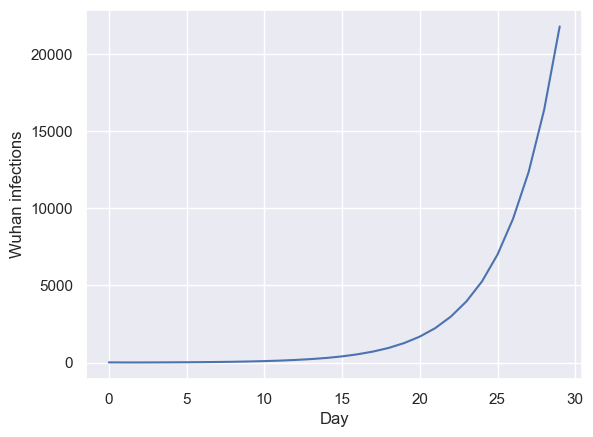

In [5]:
sim = covid_ode_model(beta=1.94, gamma=0.62, I_0=15.0)

plt.plot(sim.times, sim.states[:, WUHAN_IDX, 2])
plt.ylabel("Wuhan infections")
_ = plt.xlabel("Day")

## Adding observation noise

To fit the model to data, we need to build an observation model around the ODE process.  To do this, we use TensorFlow Probability's `JointDistributionCoroutineAutoBatched` class, showing how `gemlib` objects are compatible with TFP objects.  Note that in the original Read _at al._ paper, observations from Chinese cities had been aggregated up to the 10th January.  We account for this using the helper function `expected_observed_cases` which returns a data structure performing this aggregation.

As above, we encapsulate the model definition to reflect the probabilistic conditioning

$$
\mathbf{y},\mathbf{z} \sim \mbox{SEIRwithPoissonNoise}(\beta, \gamma, \phi, I_0)
$$

In [6]:
def covid_joint_model(
    beta: ArrayLike,
    gamma: ArrayLike,
    phi: ArrayLike,
    I_0: ArrayLike,  # noqa: N803
    num_steps: int = 31,
) -> tfd.JointDistributionCoroutineAutoBatched:
    china_population = np.asarray(ds["china_population"])
    world_connectivity = np.asarray(ds["world_connectivity"])

    @tfd.JointDistributionCoroutineAutoBatched
    def observation_model():
        # Solve ODEs
        seir = covid_ode_model(beta, gamma, I_0, num_steps)

        # Case ascertainment vector is 1 apart from at WUHAN_IDX
        case_ascertainment_prob = (
            jnp.ones_like(china_population).at[WUHAN_IDX].set(phi)
        )

        # China observation model
        exp_obs_cases = expected_observed_cases(seir.states)

        yield tfd.Poisson(
            rate=exp_obs_cases * case_ascertainment_prob,
            name="china_cases",
        )

        # World observation model
        china_prev = (
            seir.states[..., 2] / china_population * case_ascertainment_prob
        )
        world_rate = jnp.matvec(world_connectivity, china_prev)

        yield tfd.Poisson(rate=world_rate[:-1], name="world_cases")

    return observation_model

To test our model setup, we'll create a model object with $\beta=1.94$, $\gamma=0.6$ and 15.0 initial infectives

In [7]:
model = covid_joint_model(beta=1.94, gamma=0.6, phi=0.05, I_0=15.0)

and compute the log-probability of observing cases in China and the rest of the world, the `JointDistributionCoroutineAutoBatched` object provides a `log_prob` method which takes a tuple of values for the random variables in our model in the order in which they were declared.

In [8]:
observed_cases = (
    np.asarray(ds["china_cases"])[10:],
    np.asarray(ds["world_cases"]),
)
model.log_prob(*observed_cases)

Array(-14289.53320507, dtype=float64)

Note that at no stage above have we invoked any computational logic.  We have merely _declared_ explicitly the assumptions of our model, and the various aggregations and aspects of the data we have observed.

## Computing the MLE of the parameters

Having fully specified our data generating model conditional on demographic data, we now wish to estimate the parameters $\beta$, $\gamma$, and the number of initial infective individuals by maximum likelihood.  We begin by constructing a function that returns the negative log probability (negative log-likelihood) of observing `data` (i.e. our case timeseries) given `parameters`.  To speed up computation, we decorate the objective function with `@jax.jit` to enable JAX's just-in-time compiler

In [9]:
@jax.jit
def obj_fn(data, params):
    model = covid_joint_model(*jnp.unstack(params))
    return -model.log_prob(*data)

This objective function can then be used in an off-the-shelf optimiser, such as TensorFlow Probability's Nelder-Mead implementation, to minimise this function hence maximising the log-likelihood function defined by the model.  To speed things up, we decorate 

In [10]:
results = tfp.optimizer.nelder_mead_minimize(
    lambda p: obj_fn(observed_cases, p),
    initial_vertex=np.array([17.0, 6.0, 0.05, 3.0]),
    func_tolerance=1.0e-5,
)

After checking that the optimizer converged, we unstack and print the MLE's of our parameters $\beta$, $\gamma$, and `I_0` respectively

In [11]:
assert results.converged
estimated_parameters = jnp.unstack(results.position)
estimated_parameters

(Array(15.79091466, dtype=float64),
 Array(6.35898629, dtype=float64),
 Array(0.04998377, dtype=float64),
 Array(2.99721246, dtype=float64))

## Bootstrap confidence intervals

After we have computed our Maximum Likelihood Estimates $\hat{\beta}$, $\hat{\gamma}$, and $n_0$, we can compute confidence intervals using a parametric bootstrap approach.  Using the `covid_joint_model` factory function, we create an instance of our `JointDistributionCoroutineAutoBatched` conditioned on the MLEs, and invoke the `sample` method to create 1000 simulated observed case timeseries, as if we'd been able to observe the real epidemic process multiple times.  This takes just a few seconds to achieve.

In [12]:
predictive_model = covid_joint_model(*estimated_parameters)
bootstrap_sims = predictive_model.sample(
    sample_shape=1000,
    seed=jax.random.key(0),
)

We now create a bootstrap sampling distribution for the parameters by computing an "MLE" for each simulated case timeseries.  A distinct advantage of `gemlib` being built on JAX is that we can make use of the `jax.vmap` function to automatically map the optimizer over each simulation.

Here, `jax.vmap` demands that we define the computation for a _single_ simulated case timeseries as a function that takes the timeseries as its only argument.  This function invoked the TensorFlow Probability Nelder-Mead optimizer using the `obj_fn` function above.  Note that we also use just-in-time compilation using `jax.jit` as a decorator.

In [13]:
@jax.vmap
@jax.jit
def sample_optimize(simulated_data):
    opt = tfp.optimizer.nelder_mead_minimize(
        lambda p: obj_fn(simulated_data, p),
        initial_vertex=jnp.stack(estimated_parameters),
        func_tolerance=1.0e-3,
    )
    return opt.position

This function is then mapped over the bootstrap simulations created above.  This mapped function takes considerably longer than the simple MLE optimisation above, because the serial-nature of the Nelder Mead optimizer is difficult to parallelize.  Hence `jax.vmap` serialises the individual optimisations under the hood.  Nevertheless, we still gain by avoiding untidy loop constructs and have kept any algorithm logic to a minimum.

In [14]:
bootstrap_estimates = sample_optimize(bootstrap_sims)

Having obtained the bootstrap estimates, we can compute the upper and lower 95% confidence intervals

In [15]:
ci = np.quantile(bootstrap_estimates, q=(0.025, 0.975), axis=0)
ci

array([[15.60161885,  6.25048488,  0.04792293,  2.38664846],
       [15.97524961,  6.46275601,  0.05219938,  3.69750069]])

And plot histograms of the estimated sampling distributions

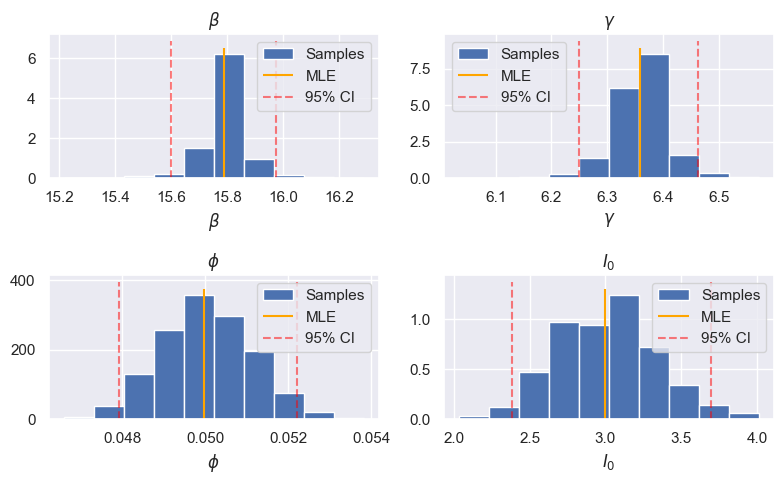

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
flat_ax = ax.flatten()
param_names = [r"$\beta$", r"$\gamma$", r"$\phi$", r"$I_0$"]

for (i, ax), param in zip(enumerate(flat_ax), param_names, strict=False):
    ax.hist(bootstrap_estimates[:, i], density=True, label="Samples")
    ax.vlines(
        estimated_parameters[i], *ax.get_ylim(), color="orange", label="MLE"
    )
    ax.vlines(
        ci[:, i],
        *ax.get_ylim(),
        linestyle="--",
        color="red",
        alpha=0.5,
        label="95% CI",
    )
    ax.set_xlabel(param)
    ax.set_title(param)
    ax.legend()

fig.tight_layout()
fig.savefig("wuhan_sampling_dists.pdf")

## Predictive distribution

We can compute a predictive distribution of the number of case detections by simulating outcome data given samples from the bootstrap samples we have from our parameter sampling distributions.  As before, we can use the convenience of `jax.vmap` to achieve this.  We construct a `vmap`ped function which takes an array of bootstrapped parameters and a KAX PRNG key, instantiates the `JointDistributionCoroutineAutoBatched` and calls the `sample` method. 

In [17]:
vec_sample = jax.vmap(
    lambda p, s: covid_joint_model(*jnp.unstack(p), num_steps=22).sample(seed=s)
)

We now call this vectorised function over `bootstrap_samples` and a corresponding array of JAX PRNG keys

In [18]:
keys = jax.random.split(jax.random.key(0), num=bootstrap_estimates.shape[0])
predictive_samples = vec_sample(bootstrap_estimates, keys)

`predictive_samples` is a named tuple containing bootstrap predictive samples from the observation model for Chinese cities, and international countries respectively.  We can, of course, summarise this distribution and plot against the original observations to assess model fit.

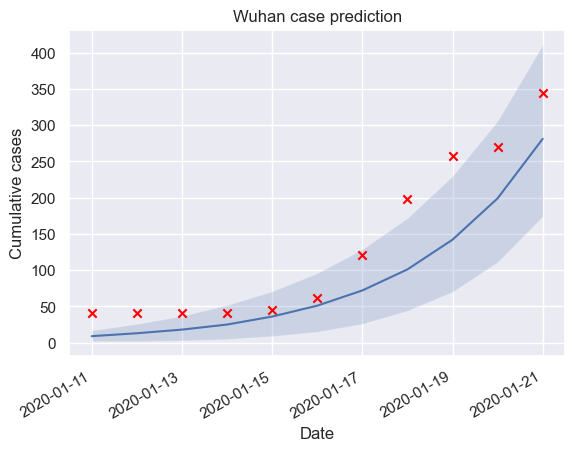

In [19]:
dates = np.arange(np.datetime64("2020-01-11"), np.datetime64("2020-01-22"))

predictive_summary = jax.tree.map(
    lambda x: np.quantile(x, axis=0, q=(0.01, 0.5, 0.99)), predictive_samples
)
predicted_wuhan_cumulative = predictive_summary.china_cases[
    :, :, WUHAN_IDX
].cumsum(axis=1)

plt.plot(dates, predicted_wuhan_cumulative[1], label="Median predicted")
plt.fill_between(
    dates,
    predicted_wuhan_cumulative[0],
    predicted_wuhan_cumulative[2],
    alpha=0.2,
)
plt.scatter(
    ds["date"][10:21],
    ds["china_cases"].cumsum(axis=0)[11:22, WUHAN_IDX],
    marker="x",
    color="red",
    label="Observed cases",
)
plt.title("Wuhan case prediction")
plt.ylabel("Cumulative cases")
plt.xlabel("Date")
plt.gcf().autofmt_xdate()